In [96]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# CoronaVirus Prediction

In [0]:
# Get data from Github
import numpy as np
from math import sqrt
from sklearn.metrics import mean_squared_error
import pandas as pd
#url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv'
url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv'
confirmed = pd.read_csv(url, error_bad_lines=False)
url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv'
death = pd.read_csv(url, error_bad_lines=False)
url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv'
recover = pd.read_csv(url, error_bad_lines=False)

## Get Population

In [0]:
population=pd.read_csv('/content/drive/My Drive/Colab Notebooks/data/population.csv', sep=',', encoding='latin1') 
confirmed=pd.merge(confirmed, population,how='left' ,on=['Province/State','Country/Region'])
death=pd.merge(death, population,how='left' ,on=['Province/State','Country/Region'])
recover=pd.merge(recover, population,how='left' ,on=['Province/State','Country/Region'])

In [134]:
# merge region
confirmed['region']=confirmed['Country/Region'].map(str)+'_'+confirmed['Province/State'].map(str)
death['region']=death['Country/Region'].map(str)+'_'+death['Province/State'].map(str)
recover['region']=recover['Country/Region'].map(str)+'_'+recover['Province/State'].map(str)
confirmed.iloc[0:11,:]

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,Population,region
0,NaN,Thailand,15.0000,101.0000,2,3,5,7,8,8,14,14,14,19,19,19,19,25,25,25,25,32,32,32,33,33,33,33,33,34,35,35,35,35,35,35,35,35,37,40,40,41,42,42,43,43,43,47,48,50,50,50,53,59,70,75,82,114,147,177,212,272,322,"69,040,000",Thailand_nan
1,NaN,Japan,36.0000,138.0000,2,1,2,2,4,4,7,7,11,15,20,20,20,22,22,45,25,25,26,26,26,28,28,29,43,59,66,74,84,94,105,122,147,159,170,189,214,228,241,256,274,293,331,360,420,461,502,511,581,639,639,701,773,839,825,878,889,924,963,"126,800,000",Japan_nan
2,NaN,Singapore,1.2833,103.8333,0,1,3,3,4,5,7,7,10,13,16,18,18,24,28,28,30,33,40,45,47,50,58,67,72,75,77,81,84,84,85,85,89,89,91,93,93,93,102,106,108,110,110,117,130,138,150,150,160,178,178,200,212,226,243,266,313,345,385,"5,612,000",Singapore_nan
3,NaN,Nepal,28.1667,84.2500,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,"29,300,000",Nepal_nan
4,NaN,Malaysia,2.5000,112.5000,0,0,0,3,4,4,4,7,8,8,8,8,8,10,12,12,12,16,16,18,18,18,19,19,22,22,22,22,22,22,22,22,22,22,22,22,23,23,25,29,29,36,50,50,83,93,99,117,129,149,149,197,238,428,566,673,790,900,1030,"31,620,000",Malaysia_nan
5,British Columbia,Canada,49.2827,-123.1207,0,0,0,0,0,0,1,1,1,1,1,1,1,1,2,2,4,4,4,4,4,4,4,4,4,4,5,5,5,5,6,6,6,6,7,7,7,7,8,8,8,9,12,13,21,21,27,32,32,39,46,64,64,73,103,103,186,231,271,"5,071,000",Canada_British Columbia
6,New South Wales,Australia,-33.8688,151.2093,0,0,0,0,3,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,6,6,13,22,22,26,28,38,48,55,65,65,92,112,134,171,210,267,307,353,"7,544,000",Australia_New South Wales
7,Victoria,Australia,-37.8136,144.9631,0,0,0,0,1,1,1,1,2,3,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,7,7,9,9,10,10,10,11,11,15,18,21,21,36,49,57,71,94,121,121,121,"92,141",Australia_Victoria
8,Queensland,Australia,-28.0167,153.4000,0,0,0,0,0,0,0,1,3,2,3,2,2,3,3,4,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,9,9,9,11,11,13,13,13,15,15,18,20,20,35,46,61,68,78,94,144,184,"5,071,000",Australia_Queensland
9,NaN,Cambodia,11.5500,104.9167,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,2,2,3,3,5,7,7,7,33,35,37,51,"16,010,000",Cambodia_nan


## Create Time Series + Plots

In [0]:
def create_ts(df):
  ts=df
  ts=ts.drop(['Province/State', 'Country/Region','Lat', 'Long',' Population '], axis=1)
  ts.set_index('region')
  ts=ts.T
  ts.columns=ts.loc['region']
  ts=ts.drop('region')
  ts=ts.fillna(0)
  ts=ts.reindex(sorted(ts.columns), axis=1)
  return (ts)

In [0]:
ts=create_ts(confirmed)
ts_d=create_ts(death)
ts_rec=create_ts(recover)

Text(0.5, 1.0, 'Daily Total Confirmed - Sri Lanka')

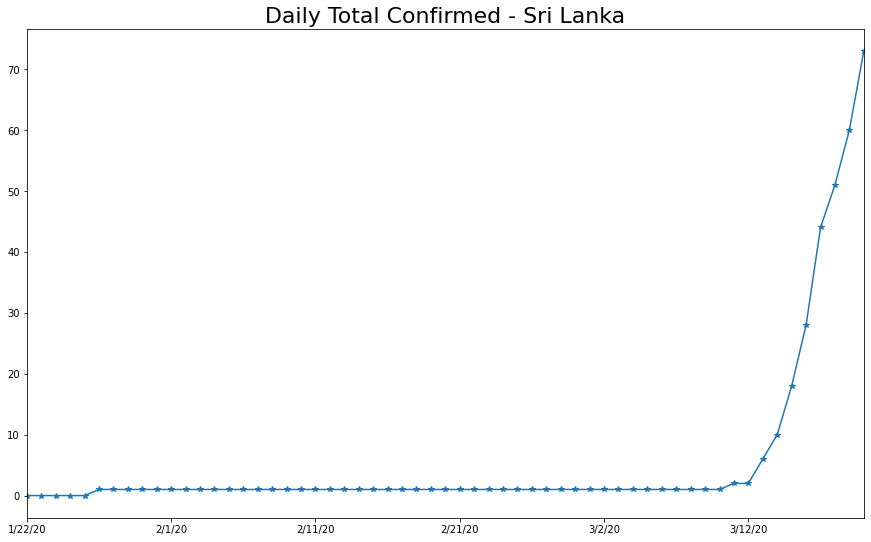

In [72]:
import matplotlib.pyplot as plt
p=ts.reindex(ts.max().sort_values(ascending=False).index, axis=1)
p.loc[:,'Sri Lanka_nan'].plot(marker='*',figsize=(15,9)).set_title('Daily Total Confirmed - Sri Lanka',fontdict={'fontsize': 22})



## Kalman Filter With R

In [0]:
# Create data for R script
ts_r=ts.reset_index()
ts_r=ts_r.rename(columns = {'index':'date'})
ts_r['date']=pd.to_datetime(ts_r['date'] ,errors ='coerce')
ts_r.to_csv(r'/content/drive/My Drive/Colab Notebooks/data/ts_r.csv')

In [92]:
import rpy2
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [93]:
%%R
install.packages('pracma')
install.packages('reshape')

/usr/local/lib/python3.6/dist-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/dist-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'https://cran.rstudio.com/src/contrib/pracma_2.2.9.tar.gz'

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/dist-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Content type 'application/x-gzip'
  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/dist-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 400551 bytes (391 KB)

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/dist-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: =
  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/dist-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/di

In [76]:
|%%R
require(pracma)
require(Metrics)
require(readr)
all<- read_csv("/content/drive/My Drive/Colab Notebooks/data/ts_r.csv")
all$X1<-NULL
date<-all[,1]
date[nrow(date) + 1,1] <-all[nrow(all),1]+1
pred_all<-NULL
for (n in 2:ncol(all)-1) {
  Y<-ts(data = all[n+1], start = 1, end =nrow(all)+1)  
  sig_w<-0.01
  w<-sig_w*randn(1,100) # acceleration which denotes the fluctuation (Q/R) rnorm(100, mean = 0, sd = 1)
  sig_v<-0.01
  v<-sig_v*randn(1,100)   
  t<-0.45
  phi<-matrix(c(1,0,t,1),2,2)
  gama<-matrix(c(0.5*t^2,t),2,1)
  H<-matrix(c(1,0),1,2)
  #Kalman
  x0_0<-p0_0<-matrix(c(0,0),2,1)
  p0_0<-matrix(c(1,0,0,1),2,2)
  Q<-0.01
  R<-0.01
  X<-NULL
  X2<-NULL
  pred<-NULL
  for (i in 0:nrow(all)) {
    namp <-paste("p", i+1,"_",i, sep = "")
    assign(namp, phi%*%(get(paste("p", i,"_",i, sep = "")))%*%t(phi)+gama%*%Q%*%t(gama))
    namk <- paste("k", i+1, sep = "")
    assign(namk,get(paste("p", i+1,"_",i, sep = ""))%*%t(H)%*%(1/(H%*%get(paste("p", i+1,"_",i, sep = ""))%*%t(H)+R)))
    namx <- paste("x", i+1,"_",i, sep = "")
    assign(namx,phi%*%get(paste("x", i,"_",i, sep = "")))
    namE <- paste("E", i+1, sep = "")
    assign(namE,Y[i+1]-H%*%get(paste("x", i+1,"_",i, sep = "")))
    namx2 <- paste("x", i+1,"_",i+1, sep = "")
    assign(namx2,get(paste("x", i+1,"_",i, sep = ""))+get(paste("k", i+1, sep = ""))%*%get(paste("E", i+1, sep = "")))
    namp2 <- paste("p", i+1,"_",i+1, sep = "")
    assign(namp2,(p0_0-get(paste("k", i+1, sep = ""))%*%H)%*%get(paste("p", i+1,"_",i, sep = "")))
    X<-rbind(X,get(paste("x", i+1,"_",i,sep = ""))[1])
    X2<-rbind(X2,get(paste("x", i+1,"_",i,sep = ""))[2])
    if(i>2){
      remove(list=(paste("p", i-1,"_",i-2, sep = "")))
      remove(list=(paste("k", i-1, sep = "")))
      remove(list=(paste("E", i-1, sep = "")))
      remove(list=(paste("p", i-2,"_",i-2, sep = "")))
      remove(list=(paste("x", i-1,"_",i-2, sep = "")))
      remove(list=(paste("x", i-2,"_",i-2, sep = "")))}
  }
  pred<-NULL
  pred<-cbind(Y,X,round(X2,4))
  pred<-as.data.frame(pred)
  pred$region<-colnames(all[,n+1])
  pred$date<-date$date
  pred$actual<-rbind(0,(cbind(pred[2:nrow(pred),1])/pred[1:nrow(pred)-1,1]-1)*100)
  pred$predict<-rbind(0,(cbind(pred[2:nrow(pred),2])/pred[1:nrow(pred)-1,2]-1)*100)
  pred$pred_rate<-(pred$X/pred$Y-1)*100
  pred$X2_change<-rbind(0,(cbind(pred[2:nrow(pred),3]-pred[1:nrow(pred)-1,3])))
  pred_all<-rbind(pred_all,pred)
}
pred_all<-cbind(pred_all[,4:5],pred_all[,1:3])
names(pred_all)[5]<-"X2"
pred_all=pred_all[with( pred_all, order(region, date)), ]
pred_all<-pred_all[,3:5]

/usr/local/lib/python3.6/dist-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Loading required package: pracma

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/dist-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Loading required package: Metrics

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/dist-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Loading required package: readr

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/dist-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Parsed with column specification:
cols(
  .default = col_double(),
  date = col_date(format = "")
)

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/dist-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: See spec(...) for full column specifications.

  warnings.warn(x, RRuntimeWarning)


In [94]:
p=%R pred_all

/usr/local/lib/python3.6/dist-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


In [0]:
############ Merge R output due to package problem
t=ts_d
t=t.stack().reset_index(name='confirmed')
t.columns=['date', 'region','confirmed']
t['date']=pd.to_datetime(t['date'] ,errors ='coerce')
t=t.sort_values(['region', 'date'])

temp=t.iloc[:,:3]
temp=temp.reset_index(drop=True)
for i in range(1,len(t)+1):
  if(temp.iloc[i,1] is not temp.iloc[i-1,1]):
    temp.loc[len(temp)+1] = [temp.iloc[i-1,0]+ pd.DateOffset(1),temp.iloc[i-1,1], 0] 
temp=temp.sort_values(['region', 'date'])
temp=temp.reset_index(drop=True)
temp['Y']=p['Y']
temp['X']=p['X']
temp['X2']=p['X2']

## Pre Proccessing Data for ML Model

### Extract Weather Data

In [0]:
# !pip install pyweatherbit

In [0]:

# from weatherbit.api import Api
# import json  
# import pandas as pd  
# from pandas.io.json import json_normalize 
# api_key = "26141d374d8e49d0a2e1f1254428ce8e"
# #api_key ="f206579c74644c4b96a2423cb56a1687"
# #api_key ="81a581ac823849f38427fb5081cb8df8"
# #api_key ="be7aaf4ff7184347aa1ebc2a2db514fe"

# api = Api(api_key)
# api.set_granularity('daily')

# # Set the granularity of the API - Options: ['daily','hourly','3hourly']
# # Will only affect forecast requests.
# #api.get_forecast(lat=lat, lon=lon)

###Weather History

In [0]:
# ################## already done since API is limited to 500 call per day

# w=pd.DataFrame(columns=['date','region','min','max'])
# for i in range (61,len(confirmed)):
#   start_date=pd.to_datetime('2020-01-22')
#   for j in range (4,confirmed.shape[1]-2):
#     jas=api.get_history(lat=confirmed.iloc[i,2], lon=confirmed.iloc[i,3], start_date=start_date.strftime('%Y-%m-%d'),end_date=(start_date+ pd.DateOffset(days=1)).strftime('%Y-%m-%d')).json
#     # j=json_normalize(j)
#     # j=j['data']
#     # max_temp=json_normalize(j['data'])['max_temp'].values[0] # max
#     # min_temp=json_normalize(j['data'])['min_temp'].values[0]
#     try:
#       w=w.append({'date':confirmed.columns[j],'region':confirmed.iloc[i,confirmed.shape[1]-1] ,'min':json_normalize(jas['data'])['min_temp'].values[0],'max':json_normalize(jas['data'])['max_temp'].values[0]}, ignore_index=True)
#     except Exception:
#       w=w.append({'date':confirmed.columns[j],'region':confirmed.iloc[i,confirmed.shape[1]-1] ,'min':None,'max':None}, ignore_index=True)
#     start_date=start_date+ pd.DateOffset(days=1)

In [0]:
# ################## Update Recent Day Weather

# w_update=pd.DataFrame(columns=['date','region','min','max'])
# for i in range (28,len(confirmed)):
#   start_date=pd.to_datetime('2020-02-17')
#   for j in range (confirmed.shape[1]-4,confirmed.shape[1]-2):
#     jas=api.get_history(lat=confirmed.iloc[i,2], lon=confirmed.iloc[i,3], start_date=start_date.strftime('%Y-%m-%d'),end_date=(start_date+ pd.DateOffset(days=1)).strftime('%Y-%m-%d')).json
#     try:
#       w_update=w_update.append({'date':confirmed.columns[j],'region':confirmed.iloc[i,confirmed.shape[1]-1] ,'min':json_normalize(jas['data'])['min_temp'].values[0],'max':json_normalize(jas['data'])['max_temp'].values[0]}, ignore_index=True)
#     except Exception:
#       w_update=w_update.append({'date':confirmed.columns[j],'region':confirmed.iloc[i,confirmed.shape[1]-1] ,'min':None,'max':None}, ignore_index=True)
#     start_date=start_date+ pd.DateOffset(days=1)

In [0]:
# w_update.to_csv(r'w_update.csv')

### Extract Weather Forecast Data

In [0]:
# ################## Forecast Weather With API - Already Done
# #forecast = api.get_forecast(lat=lat, lon=lon)

# w_forecast=pd.DataFrame(columns=['datetime','min_temp','max_temp','region'])
# for i in range (0,len(confirmed)):
#     jas=api.get_forecast(lat=confirmed.iloc[i,2], lon=confirmed.iloc[i,3]).json
#     jas=json_normalize(jas['data'])[['datetime','min_temp','max_temp']]
#     try:
#       w_forecast_temp=jas
#       w_forecast_temp['region']=confirmed.iloc[i,confirmed.shape[1]-1]
#     except Exception:
#       w_forecast_temp=pd.DataFrame(columns=['datetime','min_temp','max_temp','region'])
#     w_forecast=w_forecast.append(w_forecast_temp)
# w_forecast=w_forecast[['datetime','region','min_temp','max_temp']]
# w_forecast.columns = ['date', 'region', 'min', 'max']
# w_forecast['date']=pd.to_datetime(w_forecast['date'],format='%Y-%m-%d')

In [0]:
w=pd.read_csv('/content/drive/My Drive/Colab Notebooks/data/w.csv', sep=',', encoding='latin1')
w['date']=pd.to_datetime(w['date'],format='%d/%m/%Y')
#w['date']=pd.to_datetime(w['date'],errors ='coerce')

w_forecast=pd.read_csv('/content/drive/My Drive/Colab Notebooks/data/w_forecast.csv', sep=',', encoding='latin1')
w_forecast['date']=pd.to_datetime(w_forecast['date'],format='%d/%m/%Y')

### Build Train Set Data Structure

In [0]:
t=ts
t=t.stack().reset_index(name='confirmed')
t.columns=['date', 'region','confirmed']
t['date']=pd.to_datetime(t['date'] ,errors ='coerce')
t=t.sort_values(['region', 'date'])

# Add 1 Future day for prediction
t=t.reset_index(drop=True)
for i in range(1,len(t)+1):
  if(t.iloc[i,1] is not t.iloc[i-1,1]):
    t.loc[len(t)+1] = [t.iloc[i-1,0]+ pd.DateOffset(1),t.iloc[i-1,1], 0] 
t=t.sort_values(['region', 'date'])
t=t.reset_index(drop=True)

In [103]:
t['1_day_change']=t['3_day_change']=t['7_day_change']=t['1_day_change_rate']=t['3_day_change_rate']=t['7_day_change_rate']=t['last_day']=0
for i in range(1,len(t)):
  if(t.iloc[i,1] is t.iloc[i-2,1]):
    t.iloc[i,3]=t.iloc[i-1,2]-t.iloc[i-2,2]
    t.iloc[i,6]=(t.iloc[i-1,2]/t.iloc[i-2,2]-1)*100
    t.iloc[i,9]=t.iloc[i-1,2]
  if(t.iloc[i,1] is t.iloc[i-4,1]):
    t.iloc[i,4]=t.iloc[i-1,2]-t.iloc[i-4,2]
    t.iloc[i,7]=(t.iloc[i-1,2]/t.iloc[i-4,2]-1)*100
  if(t.iloc[i,1] is t.iloc[i-8,1]):
    t.iloc[i,5]=t.iloc[i-1,2]-t.iloc[i-8,2]
    t.iloc[i,8]=(t.iloc[i-1,2]/t.iloc[i-8,2]-1)*100
t=t.fillna(0)  
t=t.merge(temp[['date','region', 'X']],how='left',on=['date','region'])
t=t.rename(columns = {'X':'kalman_prediction'}) 
t=t.replace([np.inf, -np.inf], 0)
t['kalman_prediction']=round(t['kalman_prediction'])
train=t.merge(confirmed[['region',' Population ']],how='left',on='region')
train=train.rename(columns = {' Population ':'population'})
train['population']=train['population'].str.replace(r" ", '')
train['population']=train['population'].str.replace(r",", '')
train['population']=train['population'].fillna(1)
train['population']=train['population'].astype('int32')
train['infected_rate'] =train['last_day']/train['population']*10000
train=train.merge(w,how='left',on=['date','region'])
train=train.sort_values(['region', 'date'])
### fill missing weather 
for i in range(0,len(train)):
  if(np.isnan(train.iloc[i,13])):
    if(train.iloc[i,1] is train.iloc[i-1,1]):
      train.iloc[i,13]=train.iloc[i-1,13]
      train.iloc[i,14]=train.iloc[i-1,14]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in long_scalars
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in long_scalars
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in long_scalars
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in long_scalars
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in long_scalars
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in long_scalars
  if sys.path[0] == '':


## Kalman 1 day Prediction with Evaluation

            region         mse       rmse       mae
203  Sri Lanka_nan  120.915254  10.996147  2.542373


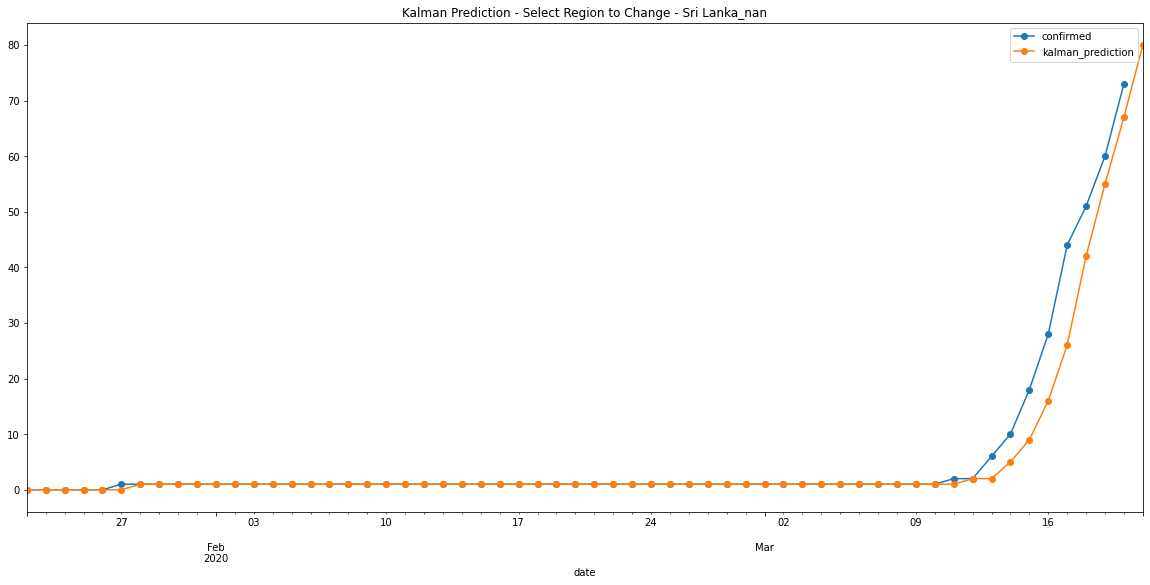

In [107]:
# Select region
region='Sri Lanka_nan'

evaluation=pd.DataFrame(columns=['region','mse','rmse','mae'])
place=0
for i in range(1,len(t)):
  if(t.iloc[i,1] is not t.iloc[i-1,1]):
    ex=np.array(t.iloc[i-len(ts):i,10])
    pred=np.array(t.iloc[i-len(ts):i,2])
    evaluation=evaluation.append({'region': t.iloc[i-1,1], 'mse': np.power((ex - pred),2).mean(),'rmse':sqrt(mean_squared_error(ex,pred)),'mae': (abs(ex - pred)).mean()}, ignore_index=True)
p=t[t['region']==region][['date','region','confirmed','kalman_prediction']]
p.iloc[len(p)-1,2]=None
p=p.set_index(['date'])
p.iloc[:,1:].plot(marker='o',figsize=(20,9)).set_title('Kalman Prediction - Select Region to Change - {}'.format(p.iloc[0,0]))
print(evaluation[evaluation['region']==p.iloc[0,0]])


In [131]:
p=t[t['region']==region][['date','region','confirmed','kalman_prediction']]
p.iloc[:,:]

,date,region,confirmed,kalman_prediction
12180,2020-01-22,Sri Lanka_nan,0,0.0
12181,2020-01-23,Sri Lanka_nan,0,0.0
12182,2020-01-24,Sri Lanka_nan,0,0.0
12183,2020-01-25,Sri Lanka_nan,0,0.0
12184,2020-01-26,Sri Lanka_nan,0,0.0
12185,2020-01-27,Sri Lanka_nan,1,0.0
12186,2020-01-28,Sri Lanka_nan,1,1.0
12187,2020-01-29,Sri Lanka_nan,1,1.0
12188,2020-01-30,Sri Lanka_nan,1,1.0
12189,2020-01-31,Sri Lanka_nan,1,1.0
